#The Project

##Importing all the required libraries 

In [418]:
#_________________________run_once__________________________
#Importing all the libraries 
from PIL import ImageDraw
import easyocr
import PIL.Image
import pandas as pd
import cv2
import numpy as np
import tensorflow as tf
import huggingface_hub
from huggingface_hub import from_pretrained_keras
import pytesseract
from tensorflow import convert_to_tensor
import matplotlib.pyplot as plt
from shapely.geometry import LineString, Polygon
import streamlit as st

##Human Segmentation Model and Functions 

In [419]:
#______________________________run_once_______________________
#Human segmentation Model and functions
pytesseract.pytesseract.tesseract_cmd="E:\\Downloads\\Streamlit\\text_image\\Tesseract-OCR\\tesseract.exe"

model = from_pretrained_keras("keras-io/deeplabv3p-resnet50")

colormap = np.array([[0,0,0], [31,119,180], [44,160,44], [44, 127, 125], [52, 225, 143],
                    [217, 222, 163], [254, 128, 37], [130, 162, 128], [121, 7, 166], [136, 183, 248],
                    [85, 1, 76], [22, 23, 62], [159, 50, 15], [101, 93, 152], [252, 229, 92],
                    [167, 173, 17], [218, 252, 252], [238, 126, 197], [116, 157, 140], [214, 220, 252]], dtype=np.uint8)
                    
img_size = 512

def predict_overlap(image):
    if image is None:
        return "Please upload an image."


def read_image(image):
    predict_overlap(image)
    image = convert_to_tensor(image)
    image.set_shape([None, None, 3])
    image = tf.image.resize(images=image, size=[img_size, img_size])
    image = image / 127.5 - 1
    return image

def infer(model, image_tensor):
    predictions = model.predict(np.expand_dims((image_tensor), axis=0))
    predictions = np.squeeze(predictions)
    predictions = np.argmax(predictions, axis=2)
    return predictions

def decode_segmentation_masks(mask, colormap, n_classes):
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    for l in range(0, n_classes):
        idx = mask == l
        r[idx] = colormap[l, 0]
        g[idx] = colormap[l, 1]
        b[idx] = colormap[l, 2]
    rgb = np.stack([r, g, b], axis=2)
    return rgb

def get_overlay(image, colored_mask):
    image = tf.keras.preprocessing.image.array_to_img(image)
    image = np.array(image).astype(np.uint8)
    overlay = cv2.addWeighted(image, 0.35, colored_mask, 0.65, 0)
    return overlay

def segmentation(input_image):
    image_tensor = read_image(input_image)
    prediction_mask = infer(image_tensor=image_tensor, model=model)
    prediction_colormap = decode_segmentation_masks(prediction_mask, colormap, 20)
    overlay = get_overlay(image_tensor, prediction_colormap)
    return (overlay, prediction_colormap)



def resize_image(image, size):
    # Resizes an image to a fixed size using bilinear interpolation
    resized_image = tf.image.resize(image, size, method=tf.image.ResizeMethod.BILINEAR)
    return resized_image

config.json not found in HuggingFace Hub.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

## Function to get Text data 

In [420]:
#___________________run_once________________________
# Function to Get Text data 
def draw_boxes(image, bounds, color='yellow', width=2):
    draw = ImageDraw.Draw(image)
    for bound in bounds:
        p0, p1, p2, p3 = bound[0]
        draw.line([*p0, *p1, *p2, *p3, *p0], fill=color, width=width)
    return image

def inference(img, lang):
    reader = easyocr.Reader(lang)
    bounds = reader.readtext(img)
    img = PIL.Image.fromarray(img)
    draw_boxes(img, bounds)
    img.save('result.jpg')
    return ['result.jpg', bounds]



## Give input here 

In [421]:
#Taking input file name 
img = cv2.imread('5_NoOverlap.png')

img = cv2.resize(img, (512, 512))
Original = img

##Extracting text data info  

In [422]:
#Get data
result = inference(img, ['en'])
#Getting text boxes 
first_lists = [t[0] for t in result[1]]
boxed = []
for i in range(len(first_lists)):
  boxed.append(first_lists[i])

## Getting human segmentation area

In [423]:
#Getting Human Segmentation

input = img
result = segmentation(input)
results = np.array(result[1])
image = results


1/1 [==============================] - 3s 3s/step


In [424]:
#Getting edges from segmented image

blur = cv2.GaussianBlur(image, (3, 3), 0)
# Apply Canny edge detection
edges = cv2.Canny(blur, 100, 200)

# Find contours
contours, hierarchy = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [425]:
# Making polygon of the contour 

contoured = [tuple(x) for sublist in contours for x in sublist]
coords = [pt[0] for pt in contoured]
curve = Polygon(coords)

## See images

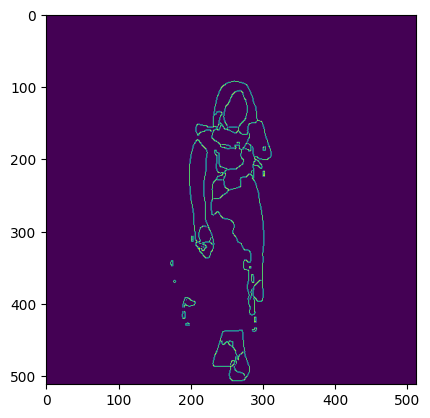

In [426]:
# See Edged image 
plt.imshow(edges)
plt.show()

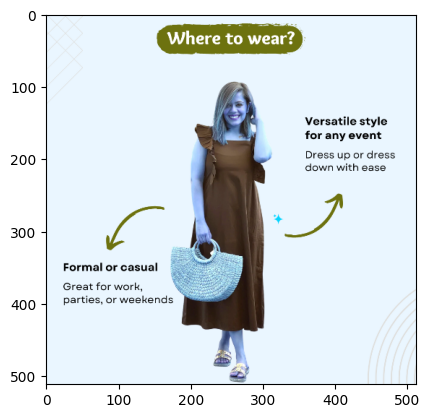

In [427]:
# See Image 
plt.imshow(Original)
plt.show()

## The Output

In [428]:
# The output 
val = 0
tot =0
for i in range(len(boxed)):
# create a Polygon object from the box points
  box = Polygon(boxed[i])
  # check if the curve intersects with the box
  if curve.intersects(box):
      val+=1
      tot+=1
  else:
      tot+=1
if (float(val/tot)>0.1):
  print(" Overlapped ")
else:
  print("Not overlapped ")

Not overlapped 
